#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.1+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [3]:
seed = 0
noise = False 
version = 1 
lr = 5e-5 
sample_size = 3000
warmup_ratio = 0.25
batch_size = 32
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25
gradient_accumulation = 2

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Medium.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.35*severity_indicator[var5] + 0.35*var9

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)
df= df[df['Instrument']==1]
# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=df.shape[0])

#### **Plot**

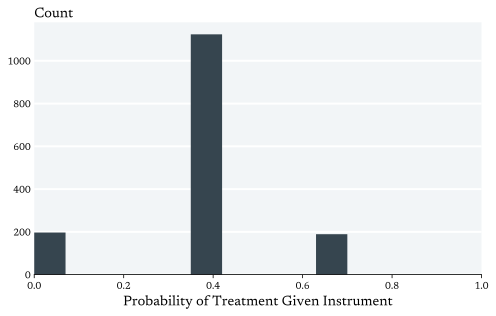

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Qlora**

In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )
additional_modules = ["attn_proj", "ff_proj"]
target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"] + additional_modules

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05, 
    target_modules='all-linear',
    bias="none",
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [12]:
model_name = "microsoft/Phi-3-mini-4k-instruct" #'meta-llama/Meta-Llama-3-8B-Instruct' #"microsoft/Phi-3-mini-4k-instruct"#'meta-llama/Meta-Llama-3-8B-Instruct' #"microsoft/Phi-3-mini-4k-instruct"# #"microsoft/Phi-3-mini-4k-instruct" #meta-llama/Meta-Llama-3-8B-Instruct" 

from transformers.utils import is_flash_attn_2_available
print(is_flash_attn_2_available())
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                            device_map="auto", 
                                            torch_dtype=torch.bfloat16,
                                            trust_remote_code=True,
                                            quantization_config=bnb_config,
                                            attn_implementation="flash_attention_2")# So we can do gradient checkpointing

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

model.config.use_cache = False # Conflixt with gradient checkpointing
model.config.pretraining_tp = 1
model.generation_config.temperature = 0.001
model.enable_input_require_grads()
print(model.generation_config)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000,
  "temperature": 0.001
}

trainable params: 25,165,824 || all params: 3,846,245,376 || trainable%: 0.6543
None


#### **Tokenizer**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to left
tokenizer.padding_side = 'left'

def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Create Dataset**

In [14]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    # Initialize the dataset list
    dataset = []
    treated_dataset = []
    control_dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        treated_entry = [
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        
        control_entry = [
            {'content': f"Task: {row['Control_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        dataset.append(entry)
        treated_dataset.append(treated_entry)
        control_dataset.append(control_entry)

    dataset = Dataset.from_dict({'messages': dataset})
    treated_dataset = Dataset.from_dict({'messages': treated_dataset})
    control_dataset = Dataset.from_dict({'messages': control_dataset})

else:
    # Initialize the dataset list
    dataset = []
    treated_dataset = []
    control_dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        dataset.append(entry)


        treated_entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        treated_dataset.append(treated_entry)

        control_entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        control_dataset.append(control_entry)

    dataset = Dataset.from_dict({'messages': dataset})
    treated_dataset = Dataset.from_dict({'messages': treated_dataset})
    control_dataset = Dataset.from_dict({'messages': control_dataset})

#### **Token Length**

(array([ 30., 225., 421., 430., 277.,  95.,  25.,   4.,   2.,   1.]),
 array([266. , 283.8, 301.6, 319.4, 337.2, 355. , 372.8, 390.6, 408.4,
        426.2, 444. ]),
 <BarContainer object of 10 artists>)

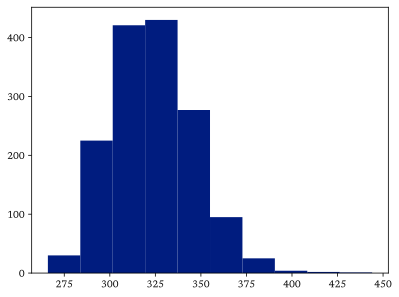

In [15]:
batched_tokens = tokenizer.apply_chat_template(dataset['messages'], tokenize=True, batched=True)
plt.hist(list(map(len, batched_tokens)))

#### **Input Type**

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

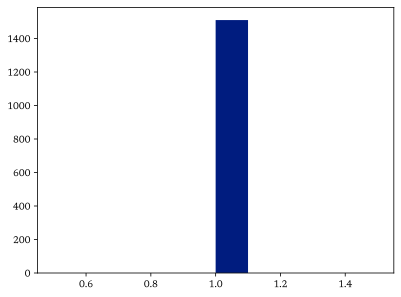

In [16]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][0]['content'] else 0 
        return example
else:
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][1]['content'] else 0 
        return example

dataset = dataset.map(get_input_id, batched=False)
treated_dataset = treated_dataset.map(get_input_id, batched=False)
control_dataset = control_dataset.map(get_input_id, batched=False)
plt.hist(dataset['type_indicator'])
plt.show()

In [17]:
tokens = tokenizer.apply_chat_template(dataset['messages'][0], tokenizer=False)
tokenizer.decode(tokens[-1])

'<|end|>'

#### **Output Type**

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

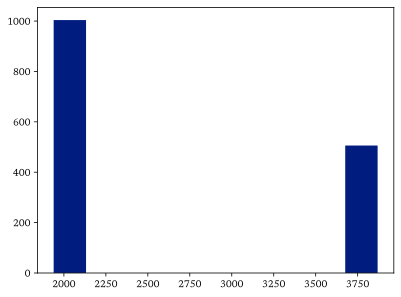

In [18]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_output_id(example):
        string = example['messages'][1]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

else:
    def get_output_id(example):
        string = example['messages'][2]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

def get_ys_id(example):
    example['yes_token'] = tokenizer.encode('Yes', add_special_tokens=False)[0] 
    return example


dataset = dataset.map(get_output_id, batched=False)
dataset = dataset.map(get_ys_id, batched=False)
dataset = dataset.add_column("fstage", df['FStage_Value'].values.tolist())
dataset = dataset.add_column("outcome", df['Outcome'].values.tolist())

treated_dataset = treated_dataset.map(get_output_id, batched=False)
treated_dataset = treated_dataset.map(get_ys_id, batched=False)
treated_dataset = treated_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
treated_dataset = treated_dataset.add_column("outcome", df['Outcome'].values.tolist())

control_dataset = control_dataset.map(get_output_id, batched=False)
control_dataset = control_dataset.map(get_ys_id, batched=False)
control_dataset = control_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
control_dataset = control_dataset.add_column("outcome", df['Outcome'].values.tolist())

plt.hist(dataset['target_token'])
plt.show()

#### **Data Loaders**

In [19]:
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)
   
tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['messages'])
 

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['messages'])
 

all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)

train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

#### **Optimizer**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_cosine_schedule_with_warmup(optimizer,num_warmup_steps= len(train_loader)*2, num_training_steps = len(train_loader)*epochs, num_cycles= 1) #int(warmup_ratio*len(train_loader)*epochs)

#### **Class Weights**

In [21]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [22]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=2,
                    gradient_accumulation=2)

print(yuri.verbose)
early_stopping = EarlyStopping(patience)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


False


#### **Training**

Epoch: 1, Train Loss: 1.4853, Val Loss: 0.8588:   0%|          | 0/30 [02:22<?, ?it/s]

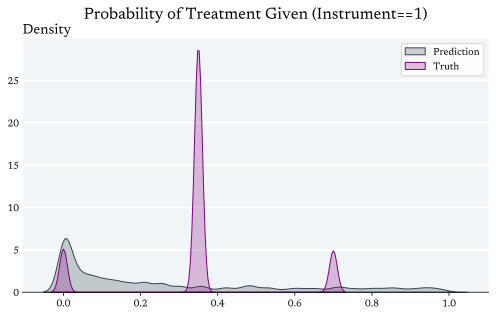

Epoch: 2, Train Loss: 0.8980, Val Loss: 0.5698:   3%|▎         | 1/30 [06:13<1:52:23, 232.52s/it]

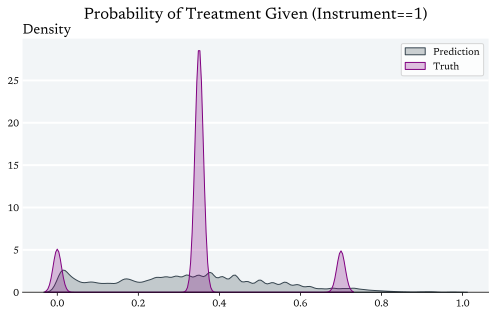

Epoch: 3, Train Loss: 0.6080, Val Loss: 0.5957:   7%|▋         | 2/30 [10:08<1:48:22, 232.23s/it]

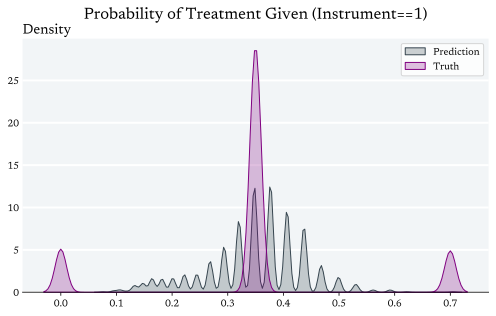

Epoch: 4, Train Loss: 0.6035, Val Loss: 0.5945:  10%|█         | 3/30 [13:54<1:43:53, 230.89s/it]

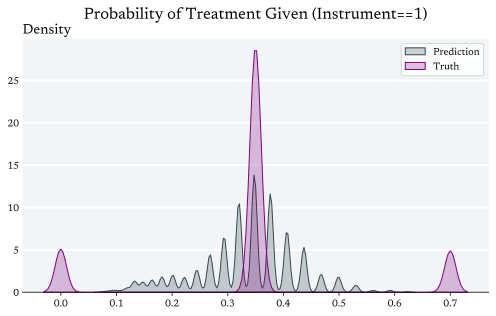

Epoch: 5, Train Loss: 0.5936, Val Loss: 0.5912:  13%|█▎        | 4/30 [17:43<1:39:18, 229.18s/it]

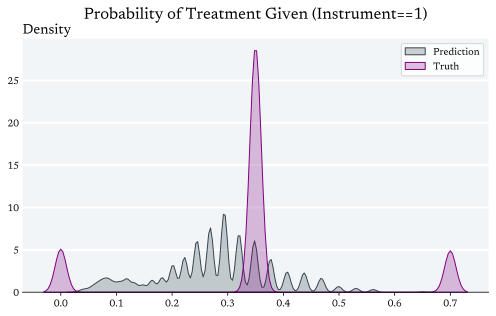

Epoch: 6, Train Loss: 0.5983, Val Loss: 0.5713:  17%|█▋        | 5/30 [21:31<1:35:25, 229.01s/it]

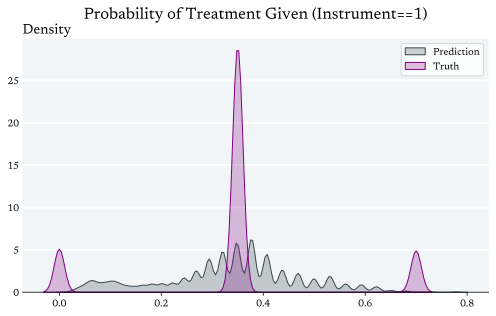

Epoch: 7, Train Loss: 0.5891, Val Loss: 0.5644:  20%|██        | 6/30 [25:18<1:31:26, 228.59s/it]

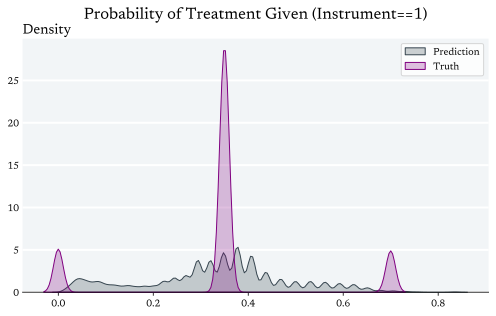

Epoch: 8, Train Loss: 0.5799, Val Loss: 0.5635:  23%|██▎       | 7/30 [29:12<1:28:03, 229.72s/it]

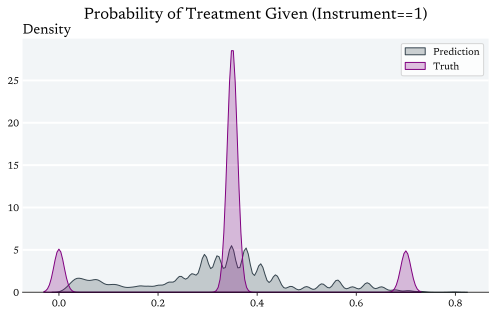

Epoch: 9, Train Loss: 0.5780, Val Loss: 0.5609:  27%|██▋       | 8/30 [32:20<1:24:41, 230.97s/it]

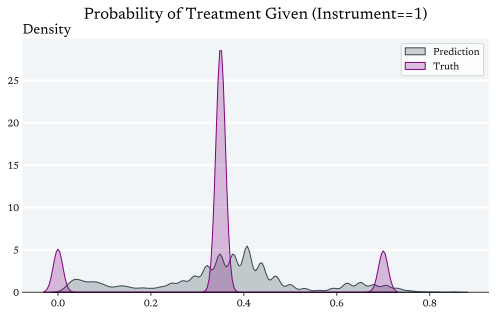

Epoch: 10, Train Loss: 0.5675, Val Loss: 0.5635:  30%|███       | 9/30 [35:27<1:16:04, 217.34s/it]

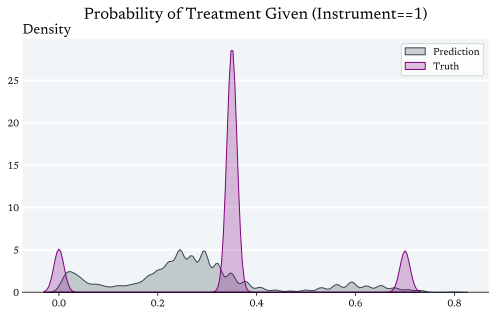

Epoch: 11, Train Loss: 0.5762, Val Loss: 0.5585:  33%|███▎      | 10/30 [38:30<1:08:49, 206.48s/it]

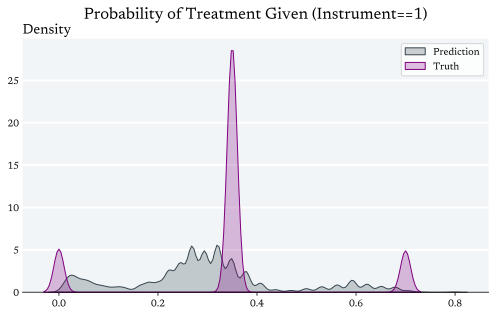

Epoch: 12, Train Loss: 0.5625, Val Loss: 0.5545:  37%|███▋      | 11/30 [41:37<1:03:32, 200.67s/it]

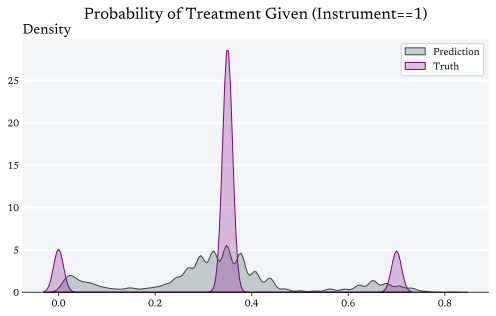

Epoch: 13, Train Loss: 0.5648, Val Loss: 0.5537:  40%|████      | 12/30 [44:45<59:01, 196.75s/it]  

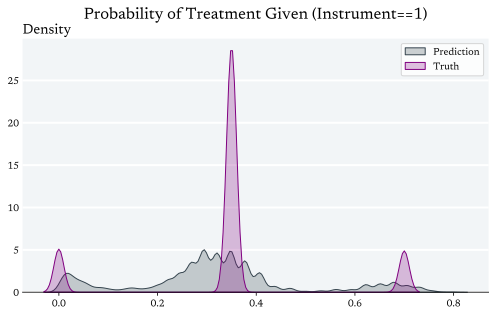

Epoch: 14, Train Loss: 0.5570, Val Loss: 0.5583:  43%|████▎     | 13/30 [47:52<54:56, 193.91s/it]

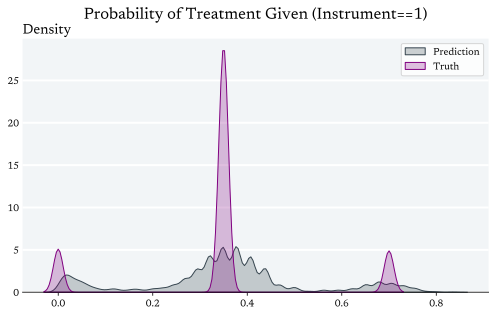

Epoch: 15, Train Loss: 0.5558, Val Loss: 0.5648:  47%|████▋     | 14/30 [50:54<50:43, 190.23s/it]

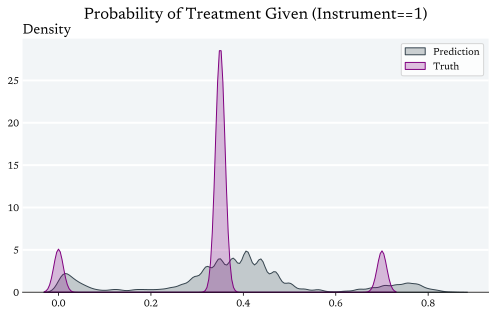

Epoch: 16, Train Loss: 0.5541, Val Loss: 0.5538:  50%|█████     | 15/30 [53:56<46:55, 187.70s/it]

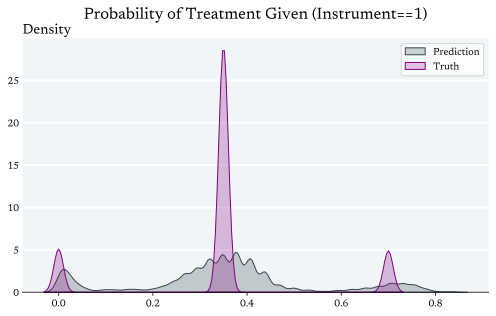

Epoch: 17, Train Loss: 0.5568, Val Loss: 0.5624:  53%|█████▎    | 16/30 [56:58<43:25, 186.09s/it]

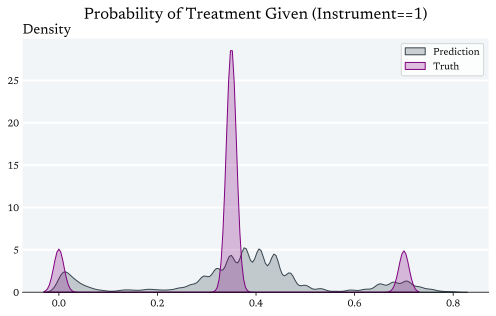

Epoch: 18, Train Loss: 0.5490, Val Loss: 0.5535:  57%|█████▋    | 17/30 [1:00:00<40:04, 184.93s/it]

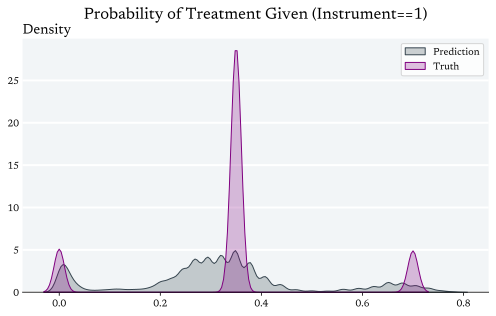

Epoch: 19, Train Loss: 0.5536, Val Loss: 0.5617:  60%|██████    | 18/30 [1:03:07<37:08, 185.73s/it]

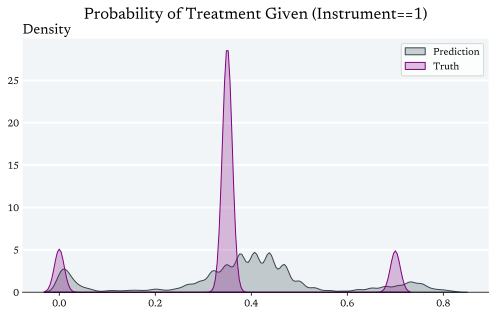

Epoch: 20, Train Loss: 0.5511, Val Loss: 0.5625:  63%|██████▎   | 19/30 [1:06:10<33:49, 184.51s/it]

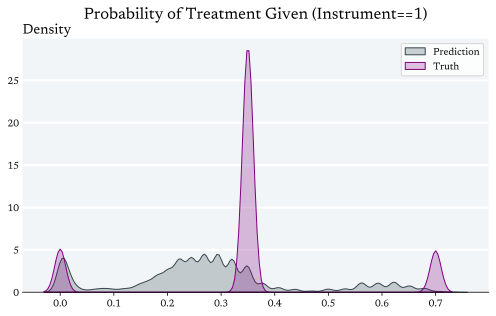

Epoch: 21, Train Loss: 0.5516, Val Loss: 0.5550:  67%|██████▋   | 20/30 [1:09:12<30:38, 183.80s/it]

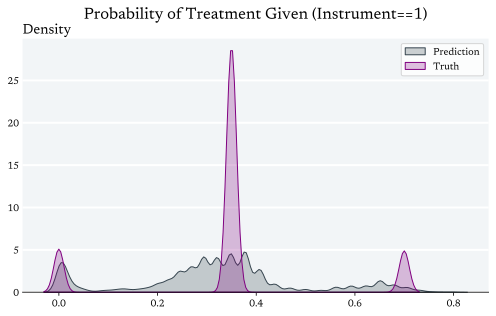

Epoch: 22, Train Loss: 0.5454, Val Loss: 0.5578:  70%|███████   | 21/30 [1:12:14<27:29, 183.31s/it]

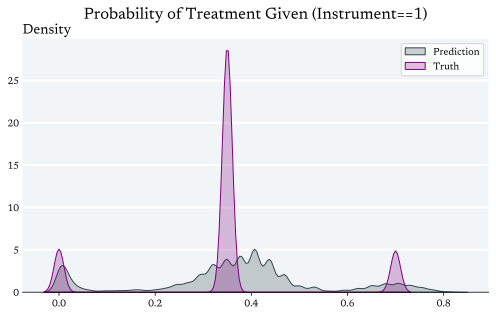

Epoch: 23, Train Loss: 0.5474, Val Loss: 0.5506:  73%|███████▎  | 22/30 [1:15:17<24:23, 183.00s/it]

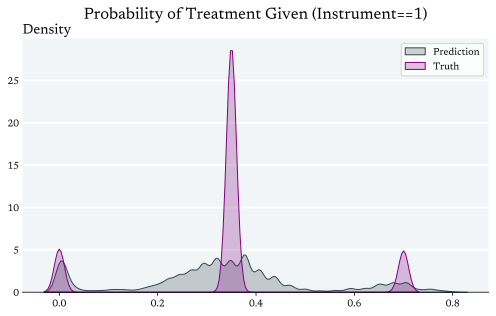

Epoch: 24, Train Loss: 0.5500, Val Loss: 0.5578:  77%|███████▋  | 23/30 [1:18:24<21:31, 184.57s/it]

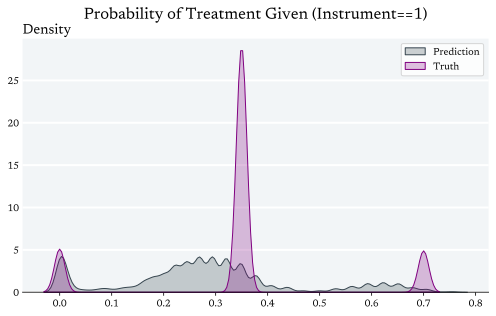

Epoch: 25, Train Loss: 0.5436, Val Loss: 0.5565:  80%|████████  | 24/30 [1:21:26<18:22, 183.82s/it]

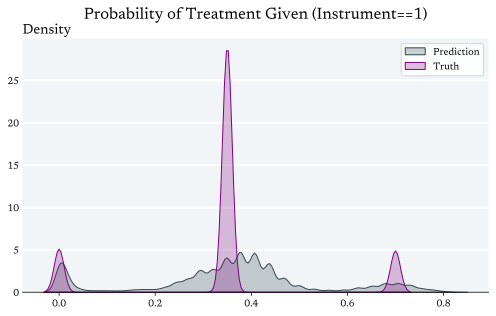

Epoch: 26, Train Loss: 0.5383, Val Loss: 0.5537:  83%|████████▎ | 25/30 [1:24:28<15:16, 183.26s/it]

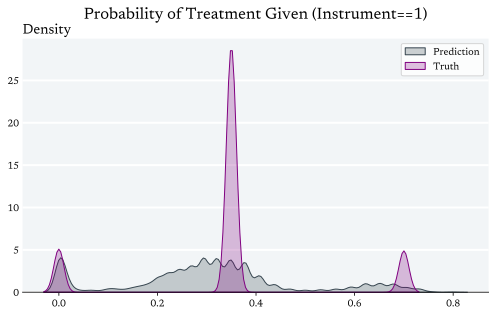

Epoch: 27, Train Loss: 0.5430, Val Loss: 0.5512:  87%|████████▋ | 26/30 [1:27:30<12:11, 182.90s/it]

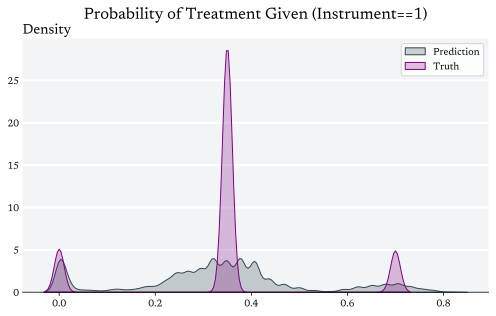

Epoch: 28, Train Loss: 0.5342, Val Loss: 0.5528:  90%|█████████ | 27/30 [1:30:32<09:07, 182.64s/it]

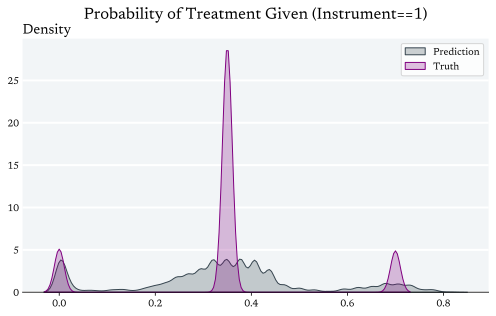

Epoch: 29, Train Loss: 0.5368, Val Loss: 0.5517:  93%|█████████▎| 28/30 [1:33:34<06:04, 182.33s/it]

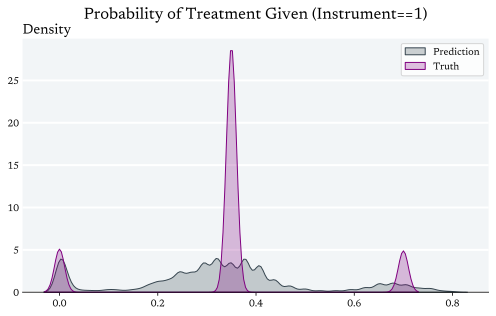

Epoch: 30, Train Loss: 0.5348, Val Loss: 0.5548:  97%|█████████▋| 29/30 [1:36:36<03:02, 182.10s/it]

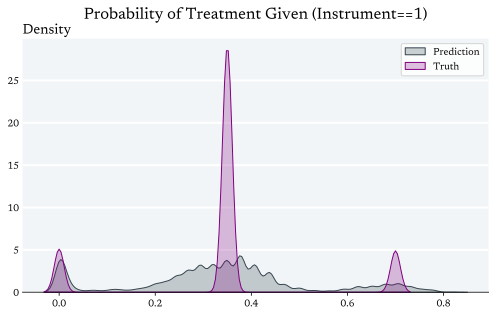

Epoch: 30, Train Loss: 0.5348, Val Loss: 0.5548: 100%|██████████| 30/30 [1:38:00<00:00, 196.02s/it]


<All keys matched successfully>

In [23]:
evaluation_losses = [yuri.evaluate(test_loader)[1]]
training_losses = [yuri.evaluate(train_loader)[1]]
lr_history = []
#recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')  #,  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss[1])
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss[1])
    lr_history.append(get_lr(optimizer))

    #recall = yuri.compute_recall(test_loader)
    #recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss[1]:.4f}, Val Loss: {val_loss[1]:.4f}')# , rYes: {recall[1]:.3f}')

        # Call early stopping
    early_stopping(val_loss[1], model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break
    _, _, log_probs, indicators, target, fstage, outcomes, texts = yuri.evaluate(data_loader=all_loader, token_type='yes_token', return_decoded_text=True, max_new_tokens=2)
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(np.exp(log_probs), color='#36454F', fill=True, bw_adjust=0.25, label='Prediction')
    sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25, label='Truth')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()
    plt.show()

yuri.model.load_state_dict(torch.load('checkpoint.pt'))

In [24]:
lr_history

[1.25e-05,
 2.5e-05,
 3.7500000000000003e-05,
 5e-05,
 4.984280524733107e-05,
 4.937319780454559e-05,
 4.8597083257709194e-05,
 4.752422169756048e-05,
 4.6168104980707107e-05,
 4.454578706170075e-05,
 4.267766952966369e-05,
 4.058724504646834e-05,
 3.830080191288342e-05,
 3.5847093477938956e-05,
 3.3256976548879184e-05,
 3.056302334890786e-05,
 2.7799111902582696e-05,
 2.5e-05,
 2.2200888097417307e-05,
 1.9436976651092144e-05,
 1.6743023451120832e-05,
 1.4152906522061048e-05,
 1.1699198087116589e-05,
 9.412754953531663e-06,
 7.3223304703363135e-06,
 5.454212938299255e-06,
 3.831895019292897e-06,
 2.475778302439524e-06,
 1.4029167422908107e-06,
 6.268021954544096e-07]

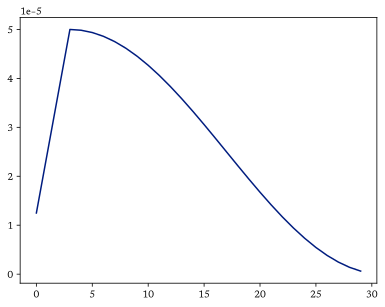

In [25]:
plt.plot(lr_history)

#### **Losses**

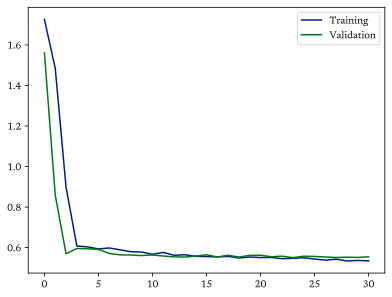

In [26]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

In [27]:
# for batch in train_loader:
#     input_ids, logits, type_indicator, target_token = yuri.process_batch(batch, 'yes_token')
#     loss, log_prob_target = yuri.compute_loss(input_ids, logits, type_indicator, target_token)
#     print(target_token)
#     print(tokenizer.decode(target_token))
#     generated_ids = yuri.model.generate(
#                         input_ids=input_ids[:,:-2],
#                         max_new_tokens=2,
#                         temperature=0.001)  # Ensure temperature is set here)
#     decoded_batch_texts = yuri.tokenizer.batch_decode(generated_ids, skip_special_tokens=False)
#     print(decoded_batch_texts)
#     break



In [28]:
_, _, log_probs, indicators, target, fstage, outcomes, texts = yuri.evaluate(data_loader=all_loader, token_type='yes_token', return_decoded_text=True, max_new_tokens=2)


In [29]:
_, _, log_probs_treatment, _, _, _, _ = yuri.evaluate(data_loader=treated_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)
_, _, log_probs_control, _, _, _, _ = yuri.evaluate(data_loader=control_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)


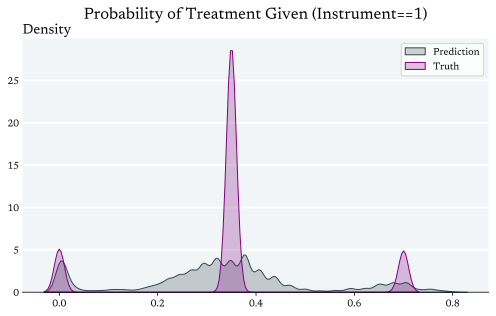

In [30]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(np.exp(log_probs_treatment), color='#36454F', fill=True, bw_adjust=0.25, label='Prediction')
sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25, label='Truth')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.show()

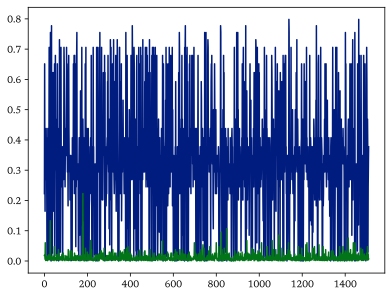

In [31]:
plt.plot(np.exp(log_probs_treatment))
plt.plot(np.exp(log_probs_control))
plt.show()

In [32]:
Y = np.array(outcomes)
residuals = np.exp(log_probs).reshape(-1,1) - (0.5*np.exp(log_probs_treatment).reshape(-1,1) + 0.5*np.exp(log_probs_control).reshape(-1,1) )

(array([174.,  31.,  65., 259., 435., 311.,  42.,  43., 119.,  31.]),
 array([-0.03230085,  0.01063229,  0.05356542,  0.09649856,  0.1394317 ,
         0.18236484,  0.22529797,  0.26823112,  0.31116426,  0.3540974 ,
         0.39703053]),
 <BarContainer object of 10 artists>)

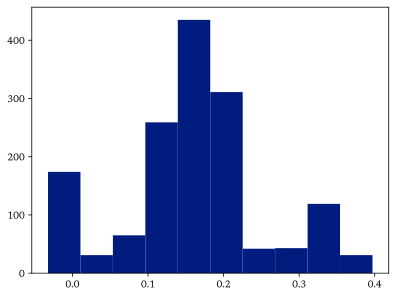

In [33]:
plt.hist(residuals)

In [34]:
est = np.linalg.lstsq( np.hstack((residuals, np.ones_like(residuals))), Y)[0]
est

array([6.012727  , 0.04451326], dtype=float32)

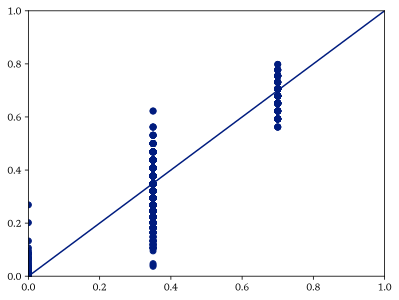

In [35]:
plt.scatter(np.array(fstage)*np.array(indicators.to('cpu')), np.exp(log_probs))
plt.plot([0,1], [0, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [36]:
x = tokenizer.apply_chat_template(dataset['messages'][1], tokenize=True, skip_special_tokens=False)
tokenizer.decode(x[-2])

'Yes'

In [37]:
for i, (j, k, l) in enumerate(zip(log_probs, target, texts)):
    print(f"Target : {k}, {torch.exp(j):.4f}")
    display(to_markdown(l))
    if i > 20:
        break

Target : No, 0.2225


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a mid-40s individual with mobility impairments who has been living in a two-story duplex for the past 45 months. They are currently late on their $1251 rent payment. The tenant lives with a roommate who contributes to the rent, and the tenant occasionally works from home due to their mobility challenges. Despite their living situation, the tenant has no pets.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : Yes, 0.6512


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 37-year-old individual with mobility impairments, living in a three-story duplex with a housing voucher. They have been residing in the duplex for the past 26 months and have a pet bird. Despite having a housing voucher, the tenant is currently behind on rent, owing $1,151. The tenant's family, who do not contribute to the rent, lives nearby, and the tenant frequently interacts with their neighbors in the duplex.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> Yes<|end|>

Target : No, 0.3206


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 48-year-old individual with mobility impairments, living in a large apartment complex for the past 6 months. They currently owe $834 in rent. Despite having a roommate who does not contribute to the rent, the tenant has managed to cultivate a collection of board games, which they enjoy playing in their free time. The tenant's living situation is challenging, as they navigate their mobility issues while also trying to keep up with the financial responsibilities of the apartment.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.1644


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 55-year-old individual who has been living in a two-story duplex for the past 46 months. They are currently behind on their rent by $1055. The tenant faces chronic health issues that have impacted their ability to maintain steady employment and meet their financial obligations. Despite these challenges, they find solace in exploring local history and landmarks, a passion they deeply cherishes. Complicating the situation further, the tenant lives with a roommate who does not contribute to the rent, adding to the financial strain. With a cat as a constant companion, the tenant navigates the delicate balance of managing their health, maintaining their living situation, and pursuing their love for local history.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.4071


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 42-year-old individual with mobility impairments, living in a large apartment complex for the past 52 months. They are currently behind on rent by $980. Despite their challenges, the tenant remains active in local charity events, demonstrating a commitment to community involvement. Complicating the situation further, the tenant's roommate does not contribute to the rent payments. This added financial strain has made it increasingly difficult for the tenant to stay current on their housing obligations.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.2941


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their late-50s who is currently behind on their rent by $1478. They have been living in a small apartment complex for the past 12 months and have a hearing impairment that affects their daily life. Despite their financial challenges, the tenant has managed to create a small garden on their balcony, finding solace in tending to the plants. They share their modest apartment with a roommate who contributes to the rent, providing some financial support. The tenant's companion, a beloved bird, adds a touch of liveliness to their home, providing them with companionship during these difficult times.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : Yes, 0.4072


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a young, visually impaired individual in their mid-20s who has been living in a two-story duplex for the past 19 months. Despite their visual impairments, they have managed to establish a comfortable life in their rented home. Unfortunately, they have fallen behind on their rent, which currently stands at $1,125. To make ends meet, the tenant relies on financial contributions from their family members to help cover the monthly payments. However, this has not been an easy situation for them. In their free time, the tenant finds solace in baking, often sharing the delicious treats they create with their friendly neighbors, showcasing their passion and talent for the culinary arts.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.2688


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual who has been residing in a three-story duplex for the past 32 months. They are currently struggling to pay the $988 monthly rent due to their psychiatric disorders, which have made it challenging for them to maintain steady employment. Despite the support of a local book club they participate in, the tenant's family members do not contribute to the rent payments. The tenant's living situation is further complicated by the presence of a dog, which adds an additional financial burden. This combination of factors has placed the tenant in a precarious position, as they strive to keep a roof over their head while managing their mental health and personal obligations.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : Yes, 0.4377


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 25-year-old individual with mobility impairments who has been living in a two-story duplex for the past 26 months. They are currently behind on their rent by $998. Despite having a roommate who does not contribute to the rent, the tenant enjoys taking part in cooking classes as a way to explore their passion for culinary arts. The challenges posed by their mobility issues, coupled with the financial strain of the rent arrears, create a complex situation for this young tenant as they navigate their living situation.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.3484


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a mid-40s individual with mobility impairments, living in a large apartment complex for the past 32 months. They are currently behind on their rent by $1397. Despite their challenges, the tenant takes pleasure in cooking on weekends and has a beloved bird as a companion. To help cover the rent, the tenant's family contributes financially, demonstrating their strong familial support system. The tenant's living situation, financial difficulties, and personal interests paint a complex picture of an individual navigating the challenges of maintaining a stable home environment.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.4073


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 52-year-old individual with mobility impairments, currently residing in a three-story duplex that they have occupied for the past 17 months. Despite their best efforts, they are struggling to keep up with the $1311 monthly rent. To supplement their income, the tenant's adult children contribute towards the rent, but the financial burden remains a constant challenge. In their limited free time, the tenant finds solace in their hobbies, spending hours knitting and engaging in various crafting activities, often accompanied by their beloved pet bird. The tenant's resilience and determination to maintain their home in the face of these difficulties are admirable, as they navigate the complexities of their situation with grace and perseverance.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.2226


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their mid-40s who is currently behind on their rent by $932. They have mobility impairments that make it challenging to get around, and they reside in a small apartment complex where they have been living for the past 18 months. Despite their situation, the tenant does not have any pets. Their family members, while present, do not contribute to the rent payments. However, the tenant finds solace in participating in a local book club, where they can engage with their community and indulge in their love for literature.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.0076


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 45-year-old individual who has been struggling with substance abuse disorders. They have been living in a three-story duplex for the past 10 months, but are currently late on their rent payment of $1170. Despite their challenges, the tenant enjoys cooking on weekends and has family members who contribute to the rent payments. The tenant's living situation reflects the complexities and difficulties they face, but also suggests their efforts to maintain a sense of stability and community.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.3207


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 35-year-old individual with Autism spectrum disorders who has been living in a large apartment complex for 18 months. They currently have a cat and are studying for an advanced degree online. Despite their efforts, the tenant has fallen behind on rent, owing $794. To make ends meet, they rely on financial contributions from their family members to help cover the rent. The tenant's situation highlights the challenges faced by individuals with Autism spectrum disorders, who may require additional support and accommodation to maintain stable housing and pursue their academic and professional goals.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.1480


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 38-year-old individual who is currently struggling to pay their monthly rent of $1133. They live in a large apartment complex and have been a tenant there for the past 38 months, utilizing a housing voucher to cover a portion of the rent. Despite having no underlying medical condition, the tenant is known to have a quick temper, which can sometimes create challenges in their daily life. The tenant also enjoys spending their free time knitting and engaging in other crafting hobbies. Unfortunately, the tenant's family members do not contribute to the rent payments, which adds to the financial strain. Overall, this tenant is facing a challenging situation as they work to maintain their housing while balancing their personal circumstances and interests.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.2017


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 45-year-old individual with visual impairments, living in a two-story duplex with a roommate. They have been residing in the duplex for 44 months and have a dog. The tenant currently owes $669 in rent. The roommate contributes to the rent, and the tenant enjoys quiet evenings at home.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.4377


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 42-year-old individual with mobility impairments who has been living in a two-story duplex for the past 8 months. They are currently late on their $857 rent payment. Despite the challenges they face with their mobility, the tenant has managed to create a cozy home environment, including a well-maintained fish tank. To help cover the rent, the tenant relies on financial contributions from their family members. Interestingly, the tenant also maintains a blog where they share their daily experiences, providing a unique perspective on navigating life with mobility limitations.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.4376


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a late-30s individual with learning disabilities who has been living in a three-story duplex for the past 9 months. They currently owe $1212 in rent. Despite their challenges, the tenant is known for their love of baking and often shares delicious treats with their neighbors. To help cover the rent, the tenant's family contributes financially. Although they face difficulties, the tenant's passion for baking and their generosity towards the community have made them a beloved member of the neighborhood.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.0052


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their mid-40s who is currently struggling to pay the $1467 rent for their small apartment in a modest complex. They have been living there for 21 months, and have a cat as a companion. The tenant exhibits certain Behavioral Traits and Conditions that contribute to their financial difficulties. They live with a roommate who does not contribute to the rent payments, further exacerbating the situation. Despite these challenges, the tenant finds solace in volunteering at a local animal shelter, where they can provide care and support to other creatures in need.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : Yes, 0.4071


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 55-year-old individual with mobility impairments, living in a three-story duplex they have occupied for the past 15 months. Despite their efforts, they are currently struggling to pay the $1145 rent. To make ends meet, they rely on financial contributions from their family members. In addition to their housing challenges, the tenant volunteers at a local animal shelter, demonstrating their commitment to their community and compassion for animals. The combination of their mobility limitations, financial strain, and dedication to volunteering paints a complex picture of a tenant facing multifaceted obstacles in maintaining their living situation.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.2941


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 49-year-old individual with mobility impairments, living in a large apartment complex for the past 24 months. They are currently behind on their rent by $927. Despite the challenges they face, the tenant has managed to maintain a small garden on their balcony, providing a sense of solace and connection to nature. Unfortunately, the tenant's living situation is further complicated by the presence of a roommate who does not contribute to the rent payments.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : Yes, 0.3773


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 35-year-old individual with mobility impairments, living in a small apartment complex for the past 50 months. They are currently struggling to pay the $1,016 monthly rent. Despite the financial strain, the tenant finds solace in playing video games during their free time. Compounding their challenges, the tenant has a roommate who does not contribute to the rent, further exacerbating the financial burden. Despite these difficulties, the tenant remains resilient, navigating their living situation with the added responsibility of caring for a beloved pet cat.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

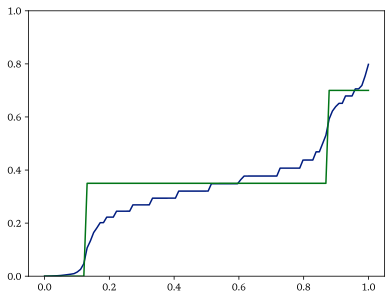

In [38]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(np.exp(log_probs)[indicators.to('cpu') == 1], qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

In [39]:
# Ensure probabilities are within (0, 1) to avoid log(0)
epsilon = 1e-15
probabilities = np.clip(df['FStage_Value'].values*df['Instrument'].values, epsilon, 1 - epsilon)

# Compute binary cross-entropy loss
bce_loss = -np.mean(df['Treatment'].values * np.log(probabilities) + (1 - df['Treatment'].values) * np.log(1 - probabilities))

print(f'Binary Cross-Entropy Loss: {bce_loss}')

Binary Cross-Entropy Loss: 0.5574122937482724
